# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


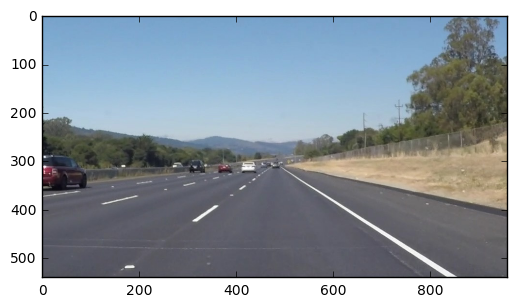

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


def hough_lines_simple(img, rho, theta, threshold):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    lines = cv2.HoughLines(img, rho, theta, threshold)
    for rho,theta in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        
        cv2.line(line_img,(x1,y1),(x2,y2),(255,0,0),10)
    
   
    return line_img

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

This image is: test_images/solidWhiteCurve.jpg with dimesions: (540, 960, 3)


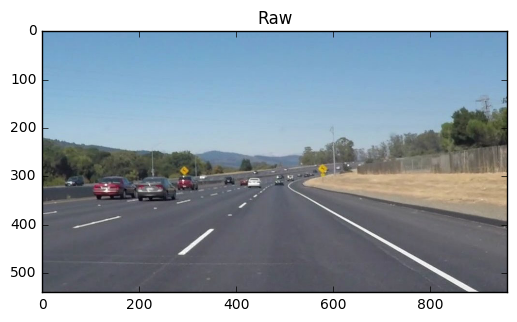

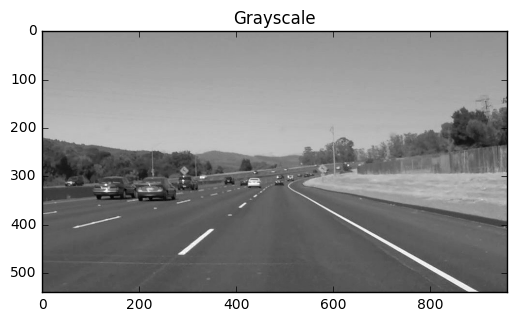

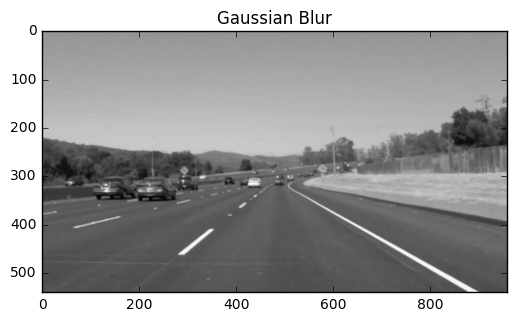

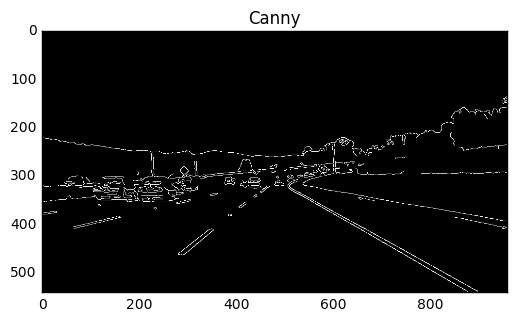

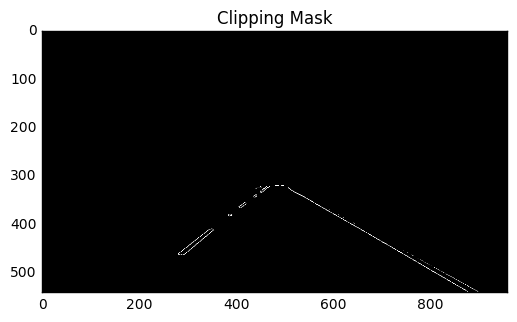

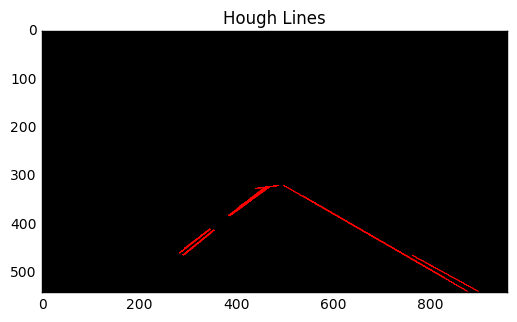

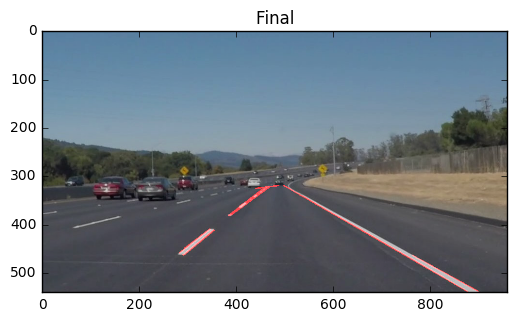

This image is: test_images/solidWhiteRight.jpg with dimesions: (540, 960, 3)


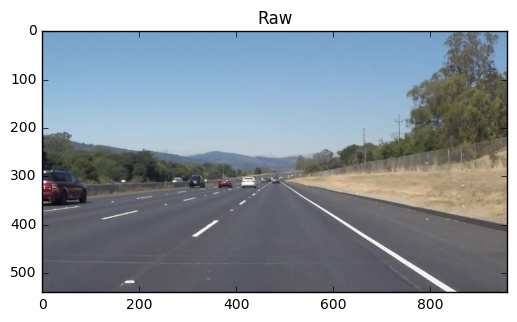

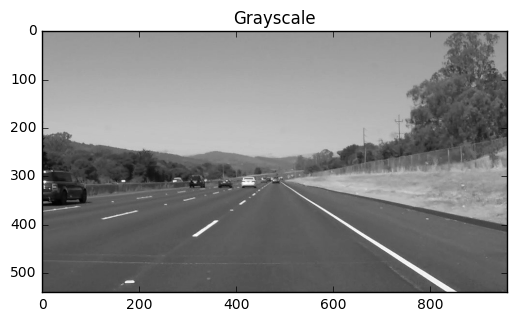

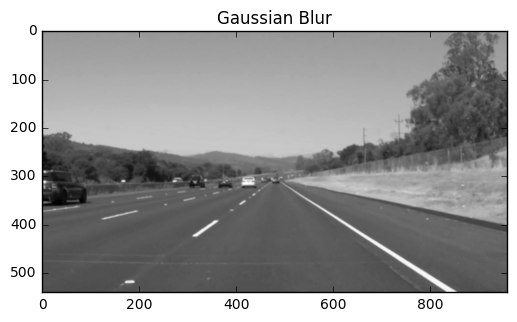

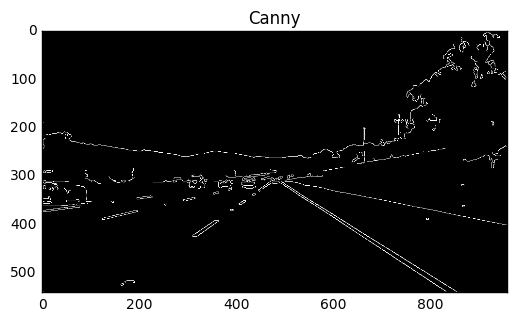

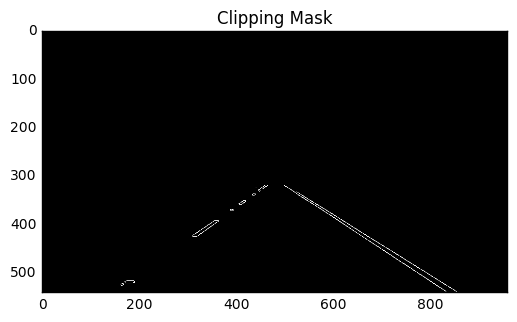

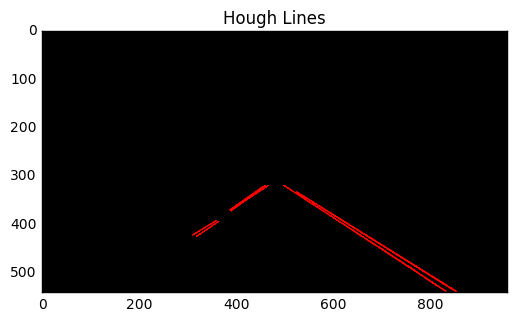

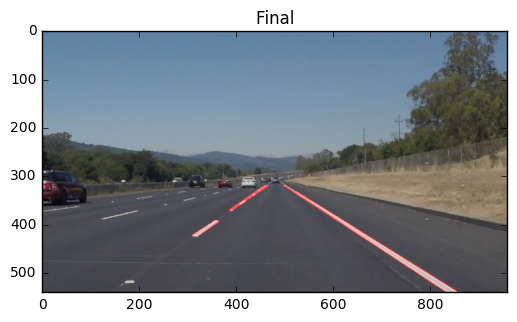

This image is: test_images/solidYellowCurve.jpg with dimesions: (540, 960, 3)


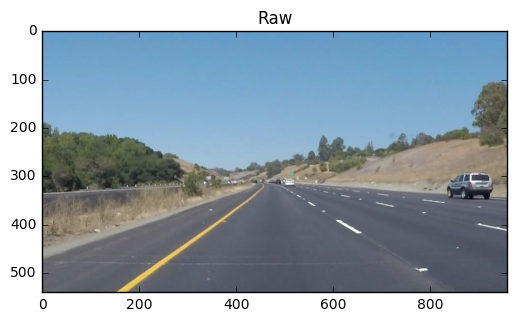

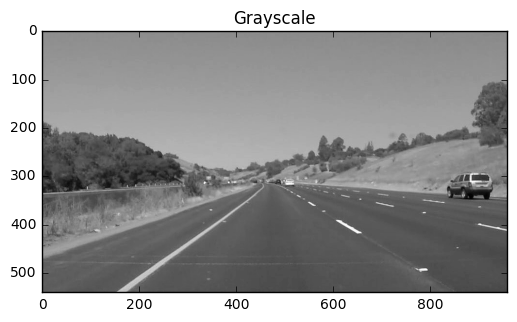

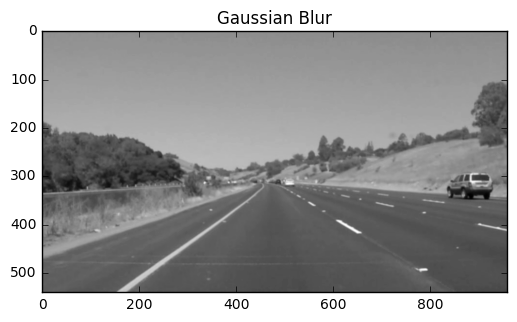

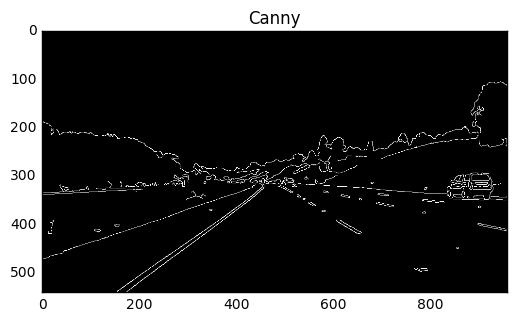

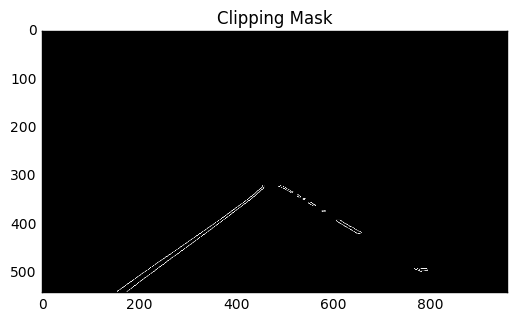

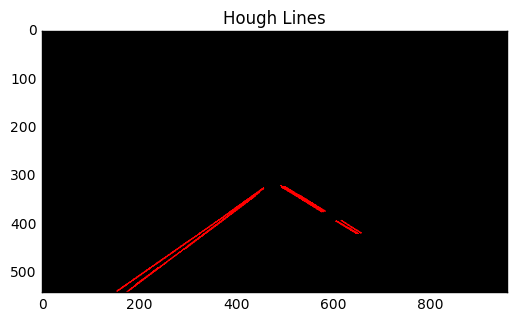

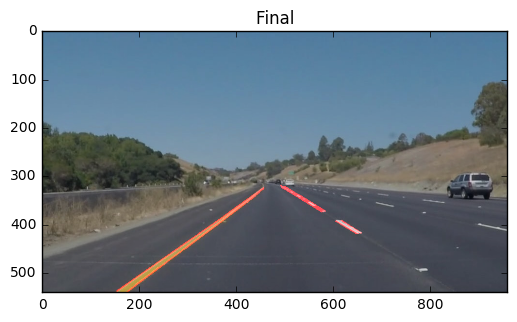

This image is: test_images/solidYellowCurve2.jpg with dimesions: (540, 960, 3)


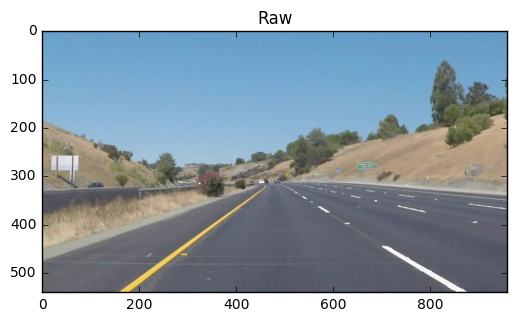

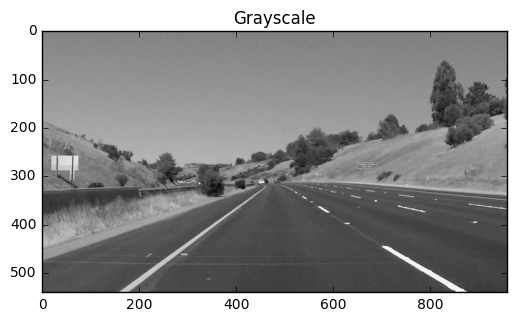

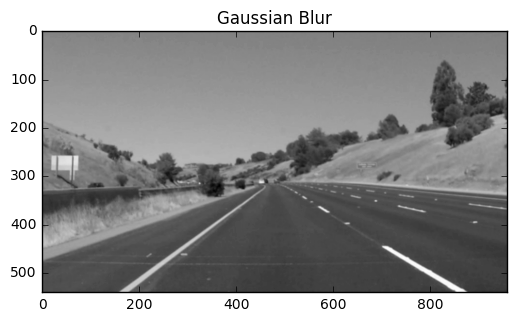

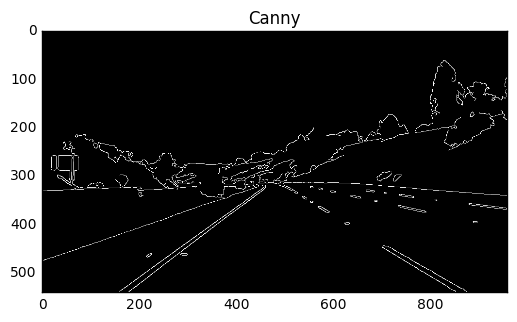

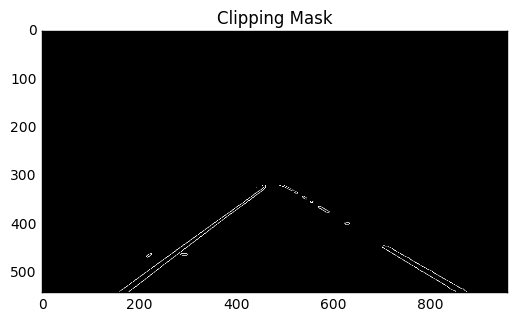

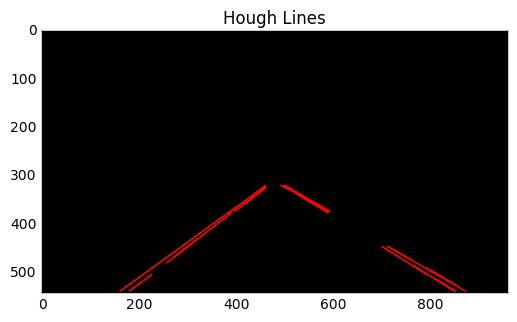

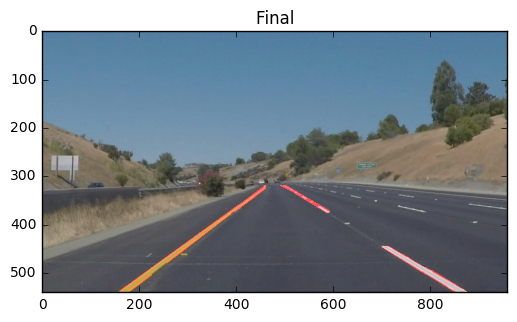

This image is: test_images/solidYellowLeft.jpg with dimesions: (540, 960, 3)


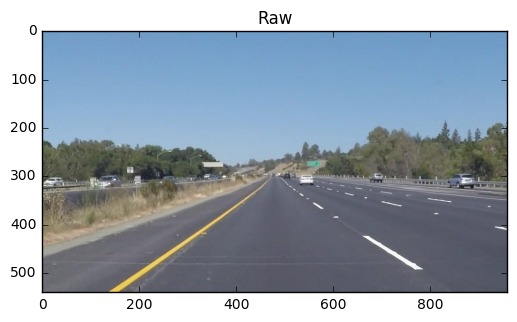

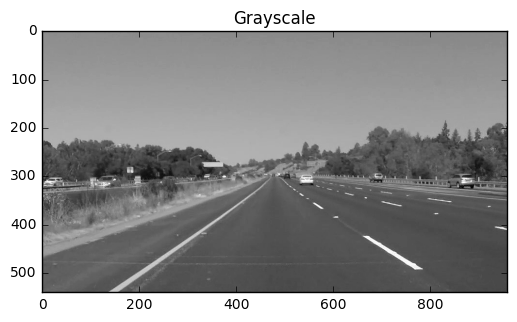

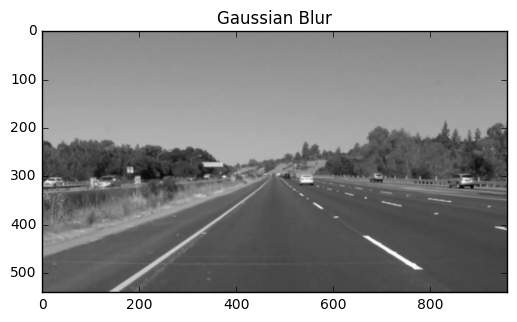

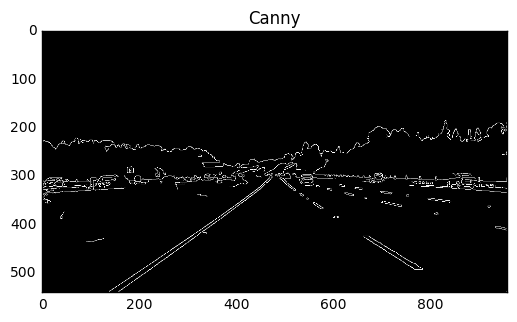

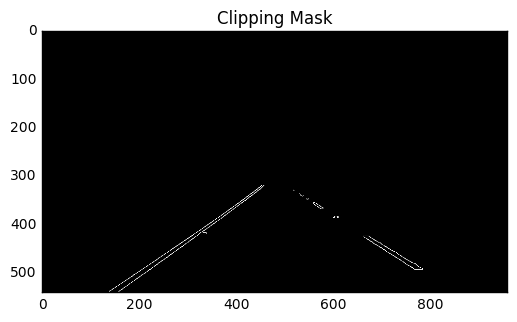

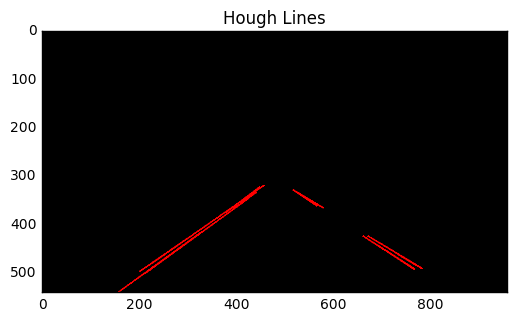

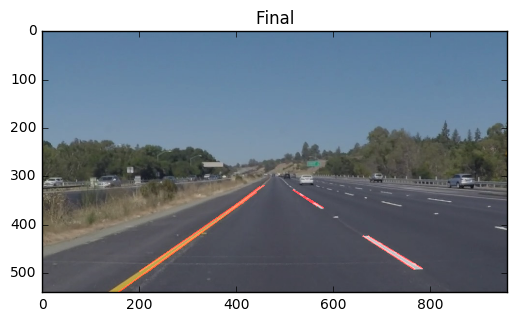

This image is: test_images/whiteCarLaneSwitch.jpg with dimesions: (540, 960, 3)


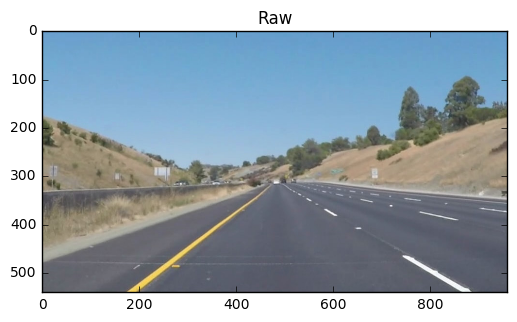

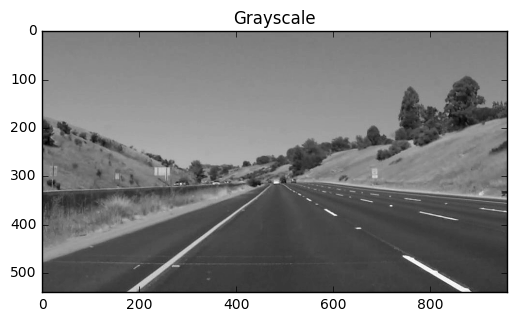

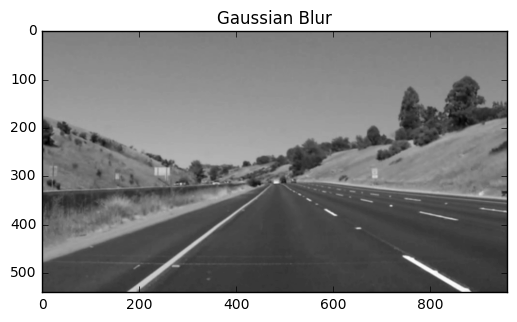

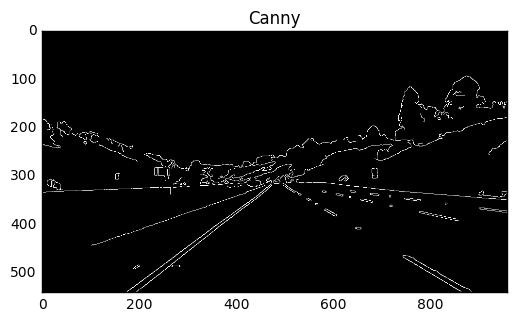

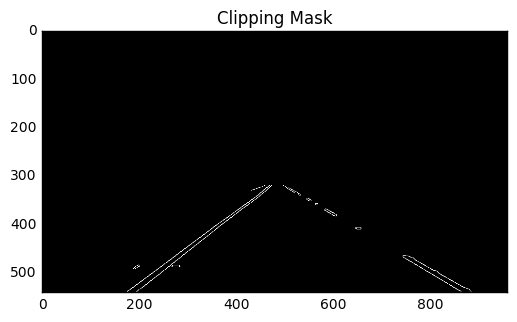

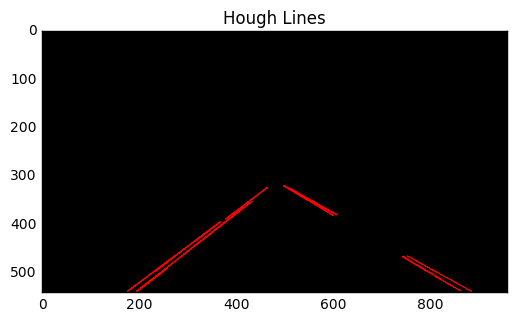

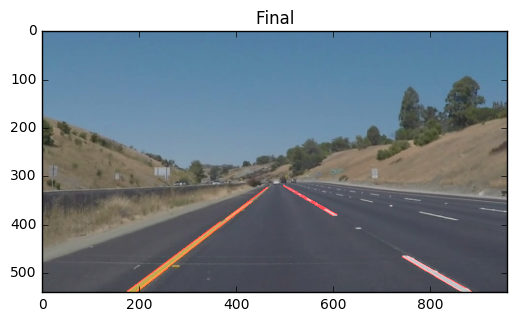

In [4]:
import os

def read_image(filename):
    #reading in an image
    image = mpimg.imread(filename)
    #printing out some stats and plotting
    print('This image is:', filename, 'with dimesions:', image.shape)
    return image

def output_image(img,title, gray = False,figure=1):
    plt.figure(figure)
    if title : plt.title(title)
    if gray: 
        plt.imshow(img,cmap='gray')
    else:
        plt.imshow(img)    
    return 

def process_image(rawimage, output=False):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    # Output reference image
    if output: output_image(rawimage,"Raw",figure=1)
    
    # Step 1 - Greyscale
    step1 = grayscale(rawimage)
    if output: output_image(step1,"Grayscale",gray=True,figure=2)
    
    # Step 2 - Simple Gaussian Blur
    step2 = gaussian_blur(step1,5); 
    if output: output_image(step2,"Gaussian Blur",gray=True,figure=3)
    
    # Step 3 - Canny
    step3 = canny(step2, 50, 150);
    if output: output_image(step3,"Canny",gray=True,figure=4)
   
    # Step 4 - Apply Clipping Mask
    imshape = image.shape
    vertices = np.array([[(50,imshape[0]),(450, 320), (500, 320), (900,imshape[0])]], dtype=np.int32)
    step4 = region_of_interest(step3, vertices)
    if output: output_image(step4,"Clipping Mask",gray=True,figure=5)

    
    # Step 5 - Hough Lines
    step5 = hough_lines(step4,2,1*np.pi/180,15,40,20)
    # step5 = hough_lines_simple(step4,1,1*np.pi/180,100)
    
    if output: output_image(step5,"Hough Lines",gray=True,figure=6)
    
    # Step 6 - Output Results
    step6 = weighted_img(step5, rawimage,0.8,1,0)
    if output: output_image(step6,"Final",gray=False,figure=7)
    
    if output: plt.show()
    return step6
    
for filename in os.listdir("test_images/"):
    if filename.endswith(".jpg"): 
        img = read_image('test_images/'+filename)
        final = process_image(img,output=True)
        cv2.imwrite('results/processed_images/'+filename,final)
        continue
    else:
        continue



run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [6]:
white_output = 'results/white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video results/white.mp4
[MoviePy] Writing video results/white.mp4


100%|█████████▉| 221/222 [00:05<00:00, 38.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/white.mp4 

CPU times: user 2.54 s, sys: 908 ms, total: 3.45 s
Wall time: 6.67 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [8]:
yellow_output = 'results/yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video results/yellow.mp4
[MoviePy] Writing video results/yellow.mp4


100%|█████████▉| 681/682 [00:19<00:00, 35.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/yellow.mp4 

CPU times: user 8.2 s, sys: 2.71 s, total: 10.9 s
Wall time: 20.3 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

## Observations from Project 1

### Results
I was able to identify the lines accurately enough (visually at least) in all of the static images and related videos. For the most part I followed the settings from the previous exercises and they proved to have the most accurate results. Step by step images are shown in the demo example above. 

### Observations


#### Horizon
While the algorithm was good at picking out the lines near to the vehicle, the accuracy dropped off significantly as the depth of field approached the horizon. This intuitively makes sense as the lines all converge at that point. The best processing seemed to occur when the clipping range was shorter. This makes the algorithm more accurate but limits how far the estimate can happen in front of the car. Given that and the algorithm speed, it isn't likely that the algorithm alone will work at higher speeds. Additional hardware or processing will be required. 

#### Data Sets
I suspect the data sets we are using are really the optimal cases. There is very little traffic, visiblity is good, and the road is relatively flat and straight. It would be interesting to try additional data sets to see how the algorithm fares. (See additional comments below)


### Future Considerations and Investigations

#### Apriori Filtering
Right now we are taking each video image independently and calculating the results from that. This process doesn't take into consideration that the images taken close to each other in time shouldn't have big differences between them. The road lines won't move, so we should be able to use one video image to estimate and correct the next image. Likely a Kalman filter or even an averaging filter might be very useful for avoiding errors and speeding the calculations

#### Adaptive Values
We have hard-coded the parameters based upon trial and error. I'm not certain if those parameters will work in a variety of different conditions and situations. Some sort of feedback loop would be required to make sure that the parameters are working correctly. Perhaps the filters above could provide that type of feedback. 

#### Integrations
Much of the filtering and estimations can be improved with the use of additional datasets and/or hardware. Feeding parameters such as speed, orientation, direction of travel and 3d mapping should be able to help the algorithm significantly. Even provide reasonable seeds for the adaptive values


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [10]:
  



def process_image_alternate(rawimage):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
   
    # Step 1 - Greyscale
    step1 = grayscale(rawimage)
     
    # Step 2 - Simple Gaussian Blur
    step2 = gaussian_blur(step1,5); 
    
    # Step 3 - Canny
    step3 = canny(step2, 50, 150);
   

  # Step 5 - Apply Clipping Mask
    imshape = image.shape
    vertices = np.array([[(50,imshape[0]),(500, 450), (700, 450), (900,imshape[0])]], dtype=np.int32)
    step4 = region_of_interest(step3, vertices)
   
  
    # Step 4 - Hough Lines
    #step5 = hough_lines_simple(step4,1,1*np.pi/180,100)
    
    
    step5 = np.zeros((step4.shape[0], step4.shape[1], 3), dtype=np.uint8)
    lines = cv2.HoughLinesP(step4, 2, 1*np.pi/180, 15, np.array([]), 40, 20)
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x2 != x1: 
                m = (y2-y1)/(x2-x1)
            else:
                m = 0
                
            b = y1-m*x1
            
            # X Intercept filtering. We can estimate with some accuracy where the road line should be
            # with respect to the bottom of the image (depending on where they are in the lane). We can filter out slopes based on that. 
            xint = (step4.shape[0]-b) / m
                
            # Try filtering first
            if  x1 < step4.shape[1]/2 and m < 0 and xint > 0:
                cv2.line(step5, (x1, y1), (x2, y2), [0,255,0], 5)
                # extending the line doesn't add information but it's useful for visualization
                #cv2.line(step5, (int(xint), int(step4.shape[0])), (x2, y2), [0,255,0], 5)
            elif x1 > step4.shape[1]/2 and m > 0 and xint < step4.shape[1]:
                cv2.line(step5, (x1, y1), (x2, y2), [255,0,0], 5)
    
    
    
    
    # Step 6 - Output Results
    step6 = weighted_img(step5, rawimage,0.8,1,0)

    return step6

In [11]:
challenge_output = 'results/extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image_alternate)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video results/extra.mp4
[MoviePy] Writing video results/extra.mp4


100%|██████████| 251/251 [00:14<00:00, 20.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/extra.mp4 

CPU times: user 4.95 s, sys: 2.08 s, total: 7.03 s
Wall time: 15.8 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))


## Observations from Challenge Project

This project used a little more challenging data set for analysis. The standard approach (above) wasn't suitable for any type of lane detection algorithms. I suspect this could be due to a couple of issues; 

1. The sample included a curved road. This means the clipping region was likely incorrect and wasn't able to correctly isolate the lane markers

2. The sample also had a parallel concrete barrier that confused the line detection algorithms. 

The general approach that I took was execute the line detection as above and apply filter rules to eliminate excess lines that don't fit the road profile. This was done in a couple ways. 

1. Filter by slope. Since we are converging on the horizon only lines with a negative slope on the left side and positive slope on the right side of the images were considered. All other lines were removed cleaning up a portion of the data. I assumed the convergence point was in the center of the image although it should be adapted to handle a curved road and offset convergence. 

2. Filter by intercept. This was an effective filter but I suspect it won't work in all circumstances. We make the assumption that the given the camera angle the lane marker will intercept the y-origin at the bottom left of the image. We calculated the intercept and filter out any line that doesn't intersect the origin in the visible space. 

### Results

The filtering provided a moderately good response by eliminating some of the obvious errors. It did not improve the line detection it only filtered out bad data. There were segments where no line markering passed the filter and the algorithm had no data. 


### Clipping Region

One of the best ways to filter out bad data was to tweak the clipping region. I adjusted the parameters to accomodate the curving road. And this removed most of the errorneous data. However, this clipping region was set by trial and error. A better approach would be to generate the clipping region based on direction of travel and camera orientation instead. While the filtering above removed obvious errors, I suspect a more accurate clipping region provided most of the benefit in this example. 




